In [1]:
# Import and GPU Support
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import time

from B_data import create_residual_data, create_IC_data, initial_u,exact_u, create_BC_data, create_RH_data,create_RH_data_endt,Move_Time_1D,burgersDdt_godunov,godunov,exact_u_err
from B_Plotting import Burgers_plot, loss_plot 
from scipy.integrate import solve_ivp

# Full PINN
from B_PINN import NN
from B_PINN_train import pinn_train

# Burgers GPT-PINN
from B_GPT_activation import P
from B_GPT_PINN import GPT
from B_GPT_train import gpt_train

torch.set_default_dtype(torch.float)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current Device: {device}")
if torch.cuda.is_available():
    print(f"Current Device Name: {torch.cuda.get_device_name()}")

Current Device: cuda
Current Device Name: NVIDIA A100-SXM4-40GB


In [2]:
# Training Parameter Set
number_of_parameters = 11
nu1_training = np.linspace(0.0, 0.0, 1)
nu2_training  = np.linspace(0.5,1.0, number_of_parameters)
nu_training = []
for i in range(nu1_training.shape[0]):
    for j in range(nu2_training.shape[0]):
        nu_training.append([nu1_training[i],nu2_training[j]])
nu_training = np.array(nu_training)

nu_pinn_train = [0.0,1.0]
number_of_neurons = 1
P_list = np.ones(number_of_neurons, dtype=object) 

In [3]:
# Domain and Data
Xi, Xf         = -1.0, 1.5
Ti, Tf         =  0.0, 1.5
Nx_train, Nt_train =  101, 201
Nx_test, Nt_test = 101, 201
IC_pts, IC_simple = 100, 100
BC_pts =  100
N_RH = IC_pts
dx = 0.001
dt = 0.0002

residual_data = create_residual_data(Xi, Xf, Ti, Tf, Nx_train, Nt_train, Nx_test, Nt_test, dx,dt)
xt_resid      = residual_data[0].to(device)
f_hat         = residual_data[1].to(device)
xt_test       = residual_data[2].to(device)
xt_RHL      = residual_data[3].to(device)
xt_RHR      = residual_data[4].to(device)
xt_RHt         = residual_data[5].to(device)
xt_RHtL       = residual_data[6].to(device)


IC_x_test     = xt_test[0:Nx_test,:1].squeeze().cpu()
IC_t_test     = xt_test[0:Nx_test*Nt_test:Nx_test,1:].squeeze().cpu()

BC_data = create_BC_data(Xi, Xf, Ti, Tf, BC_pts)
BC1     = BC_data[0].to(device)
BC2     = BC_data[1].to(device)

#xt_RH_data = create_RH_data(Xi, Xf, Ti, Tf, IC_pts, N_RH,dx)
#xt_RH = xt_RH_data[0].to(device)
#xt_RHL = xt_RH_data[1].to(device)

In [4]:
# Setting PINN and TGPT-PINN
# Setting PINN and TGPT-PINN
layers_pinn = np.array([2, 30, 30, 30, 30, 30, 1])

lr_pinn     = 0.001
epochs_pinn = 30000
tol_pinn    = 1e-5

pinn_train_times = np.ones(number_of_neurons)

###############################################################################
################################ Training Loop ################################
###############################################################################

In [5]:
import pickle
P_list = np.ones(number_of_neurons, dtype=object)
with open('IFNN_shockrare.pkl', 'rb') as f:
    P_list = pickle.load(f)

[0.  0.5] stopped at epoch: 0 | gpt_loss: 1.0832420587539673,rMAE: [0.9999966621398926], rRMSE:[1.1782861948013306], 0.08240289241075516, 0.09994245320558548, 2.8900728921144037e-08, 0.00014142683357931674
[0.  0.5] stopped at epoch: 500 | gpt_loss: 0.09086108952760696,rMAE: 0.3472391963005066, rRMSE:0.4540857970714569, 0.01072178315371275, 0.007858650758862495, 4.584242958571849e-07, 0.00015482152230106294
[0.  0.5] stopped at epoch: 1000 | gpt_loss: 0.012349111959338188,rMAE: 0.0923854187130928, rRMSE:0.16699251532554626, 0.004938185214996338, 0.0007410041871480644, 8.847052868077299e-08, 1.861427678662153e-12
[0.  0.5] stopped at epoch: 1500 | gpt_loss: 0.013536140322685242,rMAE: 0.020357605069875717, rRMSE:0.07434143126010895, 0.00666870828717947, 0.000655969197396189, 1.4163742401152035e-09, 3.077254586969502e-05
[0.  0.5] stopped at epoch: 2000 | gpt_loss: 0.014283046126365662,rMAE: 0.019655795767903328, rRMSE:0.07417649775743484, 0.006731331814080477, 0.0006556193111464381, 1.36

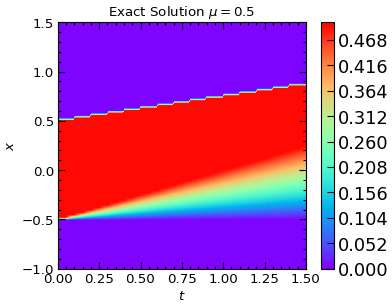

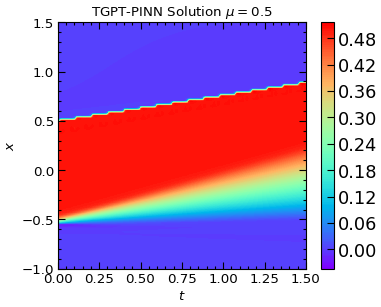

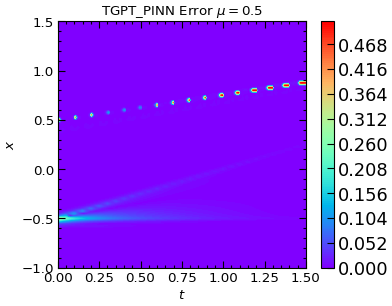

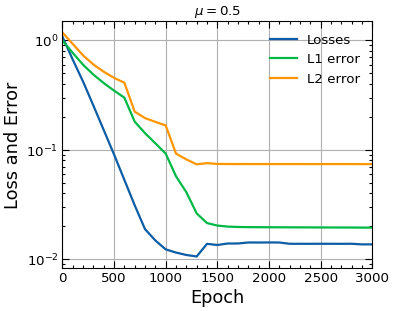

GPT-PINN at [0.  0.5] with the Loss=0.013720854185521603, rMAE = 0.0194994006305933, rRMSE = 0.07411359250545502


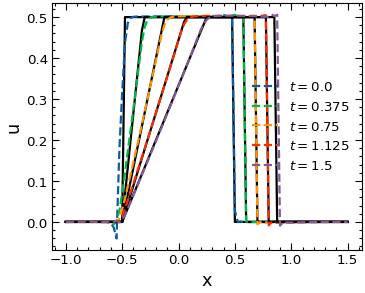

[0.   0.55] stopped at epoch: 0 | gpt_loss: 0.8791066408157349,rMAE: [0.8174036145210266], rRMSE:[0.9987700581550598], 0.0682099461555481, 0.08094821870326996, 2.8900728921144037e-08, 0.00014142683357931674
[0.   0.55] stopped at epoch: 500 | gpt_loss: 0.045512810349464417,rMAE: 0.2118542194366455, rRMSE:0.29796379804611206, 0.008675141260027885, 0.003607825143262744, 1.2099300761292398e-07, 7.582101534353569e-05
[0.   0.55] stopped at epoch: 1000 | gpt_loss: 0.005216129124164581,rMAE: 0.022499682381749153, rRMSE:0.039395712316036224, 0.0045729344710707664, 2.303026121808216e-05, 7.262344503544682e-09, 4.12819572375156e-05
[0.   0.55] stopped at epoch: 1500 | gpt_loss: 0.008878655731678009,rMAE: 0.006628080271184444, rRMSE:0.027326608076691628, 0.008723396807909012, 1.5872397796101723e-07, 9.017968594093873e-09, 1.5358187738456763e-05
[0.   0.55] stopped at epoch: 2000 | gpt_loss: 0.008332434110343456,rMAE: 0.006499018520116806, rRMSE:0.02745986171066761, 0.008331096731126308, 1.252506

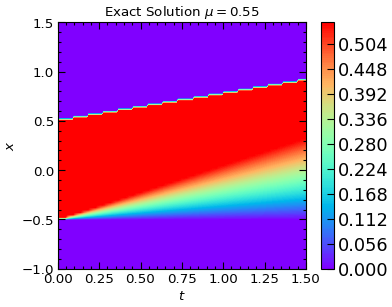

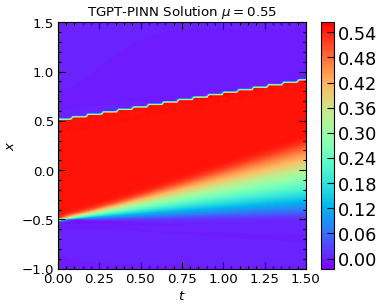

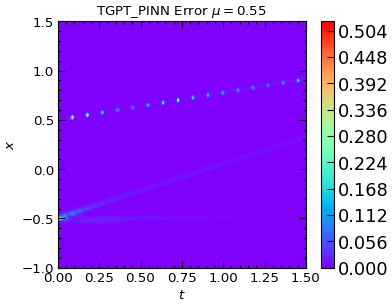

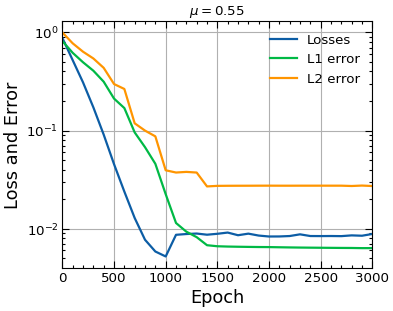

GPT-PINN at [0.   0.55] with the Loss=0.008840837515890598, rMAE = 0.0063441041857004166, rRMSE = 0.027226563543081284


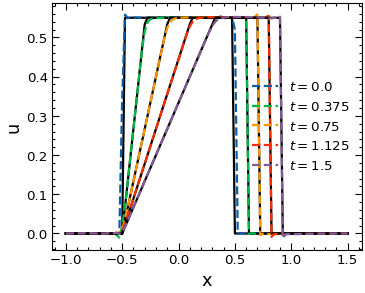

[0.  0.6] stopped at epoch: 0 | gpt_loss: 0.6972903609275818,rMAE: [0.6660922169685364], rRMSE:[0.8477755188941956], 0.056335922330617905, 0.06395398825407028, 2.8900728921144037e-08, 0.00014142683357931674
[0.  0.6] stopped at epoch: 500 | gpt_loss: 0.025530735030770302,rMAE: 0.136132150888443, rRMSE:0.20721319317817688, 0.008398910984396935, 0.0016733690863475204, 9.444423909599209e-08, 3.971879050368443e-05
[0.  0.6] stopped at epoch: 1000 | gpt_loss: 0.011360418051481247,rMAE: 0.010328559204936028, rRMSE:0.03962402418255806, 0.010901846922934055, 4.724830432678573e-06, 1.084886402935581e-08, 4.112146780244075e-05
[0.  0.6] stopped at epoch: 1500 | gpt_loss: 0.01192951574921608,rMAE: 0.006527243182063103, rRMSE:0.029222918674349785, 0.011013936251401901, 1.0647543291497641e-07, 9.927219046801383e-09, 9.144148498307914e-05
[0.  0.6] stopped at epoch: 2000 | gpt_loss: 0.011279859580099583,rMAE: 0.006398116238415241, rRMSE:0.028932616114616394, 0.010798740200698376, 9.858460003897562e-

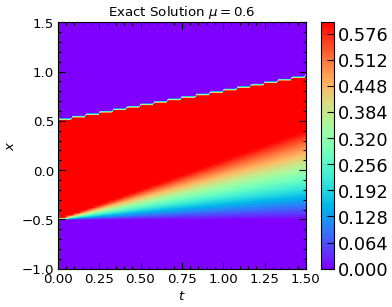

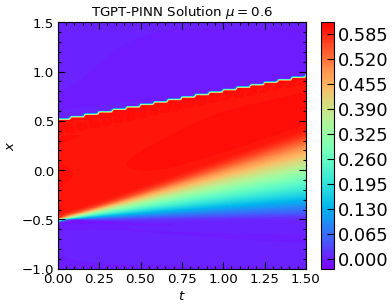

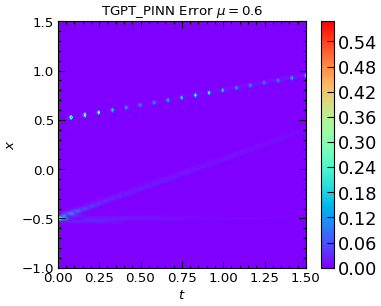

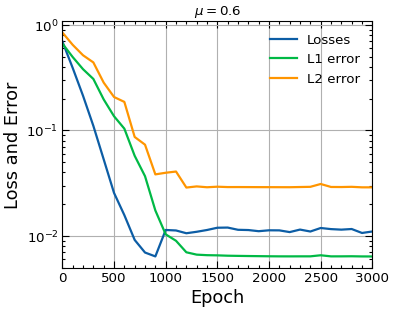

GPT-PINN at [0.  0.6] with the Loss=0.010990702547132969, rMAE = 0.006370834074914455, rRMSE = 0.028816616162657738


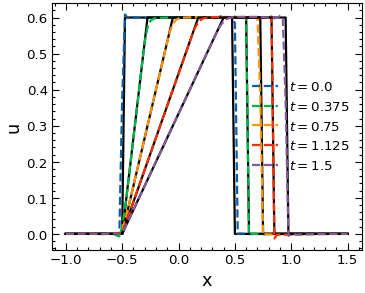

[0.   0.65] stopped at epoch: 0 | gpt_loss: 0.5377932190895081,rMAE: [0.5381478667259216], rRMSE:[0.7177845239639282], 0.04678083583712578, 0.04895978420972824, 2.8900728921144037e-08, 0.00014142683357931674
[0.   0.65] stopped at epoch: 500 | gpt_loss: 0.015847794711589813,rMAE: 0.0853094533085823, rRMSE:0.15982136130332947, 0.008745400235056877, 0.0006313878111541271, 2.9300530002274172e-08, 7.882234785938635e-05
[0.   0.65] stopped at epoch: 1000 | gpt_loss: 0.013883215375244617,rMAE: 0.007679180707782507, rRMSE:0.03898952901363373, 0.013875175267457962, 7.926362286525546e-07, 1.1400361543678628e-08, 2.54099367415217e-12
[0.   0.65] stopped at epoch: 1500 | gpt_loss: 0.01457846350967884,rMAE: 0.006690935231745243, rRMSE:0.035460274666547775, 0.014576797373592854, 1.561806328709281e-07, 1.0388114368709012e-08, 2.794734929589815e-12
[0.   0.65] stopped at epoch: 2000 | gpt_loss: 0.01505693793296814,rMAE: 0.006756975781172514, rRMSE:0.0366678461432457, 0.014319416135549545, 1.416410952

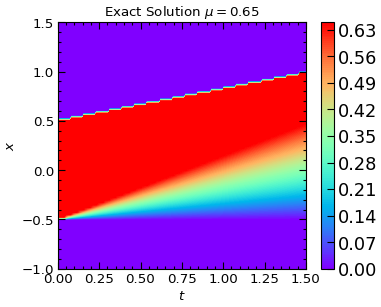

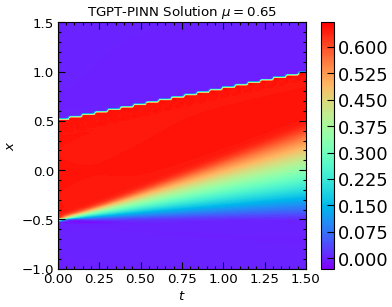

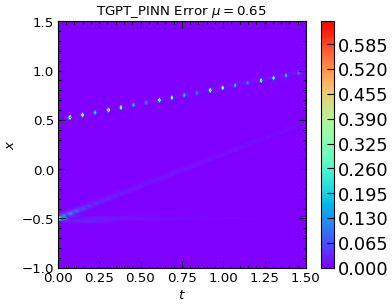

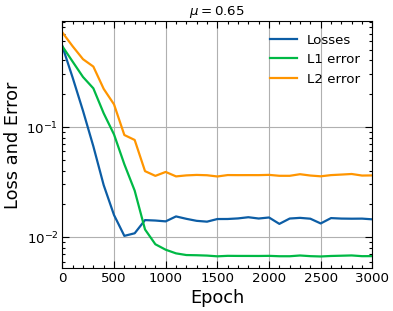

GPT-PINN at [0.   0.65] with the Loss=0.014487936161458492, rMAE = 0.0067191277630627155, rRMSE = 0.03626095503568649


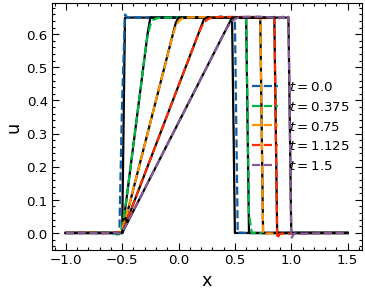

[0.  0.7] stopped at epoch: 0 | gpt_loss: 0.40061476826667786,rMAE: [0.4284147024154663], rRMSE:[0.6039488911628723], 0.03954464569687843, 0.03596555441617966, 2.8900728921144037e-08, 0.00014142683357931674
[0.  0.7] stopped at epoch: 500 | gpt_loss: 0.012749552726745605,rMAE: 0.050331469625234604, rRMSE:0.13103467226028442, 0.010985007509589195, 0.00017644380568526685, 1.0699688246518235e-08, 3.739907255412289e-12
[0.  0.7] stopped at epoch: 1000 | gpt_loss: 0.017339982092380524,rMAE: 0.007106513250619173, rRMSE:0.040554359555244446, 0.017336171120405197, 3.693989185649116e-07, 1.160809759426229e-08, 3.000115780804613e-12
[0.  0.7] stopped at epoch: 1500 | gpt_loss: 0.017319247126579285,rMAE: 0.006971576251089573, rRMSE:0.0400821715593338, 0.01690509356558323, 2.812128343521181e-07, 1.1172279101856475e-08, 4.1122861148323864e-05
[0.  0.7] stopped at epoch: 2000 | gpt_loss: 0.017267493531107903,rMAE: 0.006961731240153313, rRMSE:0.039968617260456085, 0.01685335487127304, 2.7972615157523

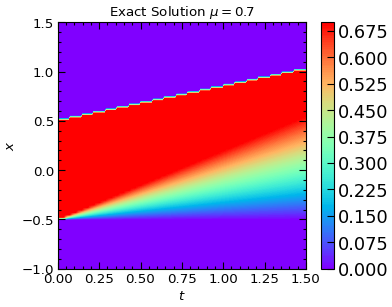

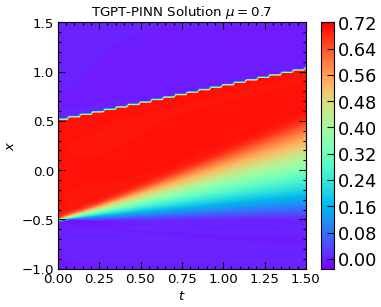

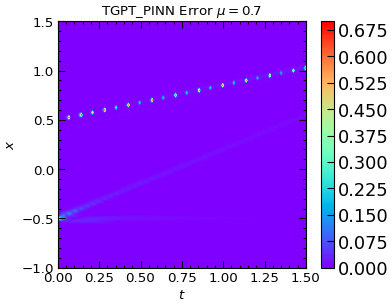

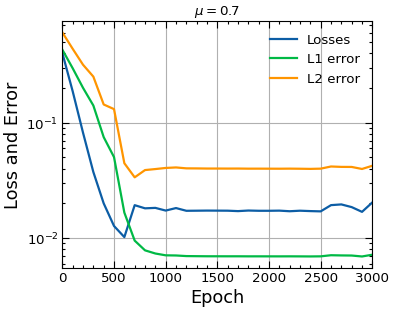

GPT-PINN at [0.  0.7] with the Loss=0.02040102891623974, rMAE = 0.007192057091742754, rRMSE = 0.042373958975076675


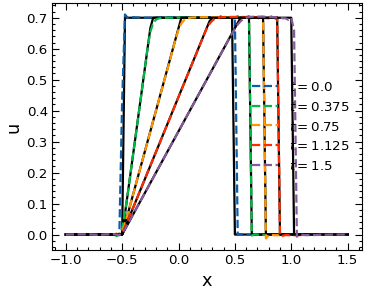

[0.   0.75] stopped at epoch: 0 | gpt_loss: 0.2857552170753479,rMAE: [0.33272042870521545], rRMSE:[0.5014628767967224], 0.03462737798690796, 0.02497132681310177, 2.8900728921144037e-08, 0.00014142683357931674
[0.   0.75] stopped at epoch: 500 | gpt_loss: 0.02049921452999115,rMAE: 0.01349484734237194, rRMSE:0.04657883197069168, 0.02005760744214058, 2.7365060304873623e-05, 1.3600821802128849e-08, 1.678214357525576e-05
[0.   0.75] stopped at epoch: 1000 | gpt_loss: 0.0205212514847517,rMAE: 0.006010232958942652, rRMSE:0.026556605473160744, 0.020167585462331772, 1.7154688691789488e-07, 1.2895341683361039e-08, 3.518222729326226e-05
[0.   0.75] stopped at epoch: 1500 | gpt_loss: 0.020450042560696602,rMAE: 0.006019593216478825, rRMSE:0.026773646473884583, 0.020096350461244583, 1.742132269555441e-07, 1.2881907096584655e-08, 3.518222729326226e-05
[0.   0.75] stopped at epoch: 2000 | gpt_loss: 0.020399082452058792,rMAE: 0.006022151093930006, rRMSE:0.026825524866580963, 0.02004537172615528, 1.7606

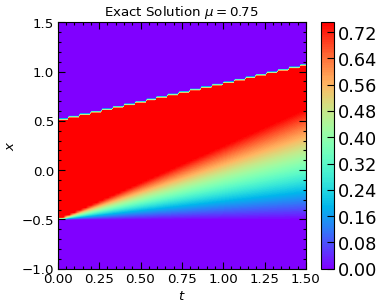

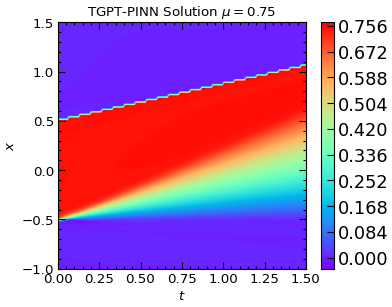

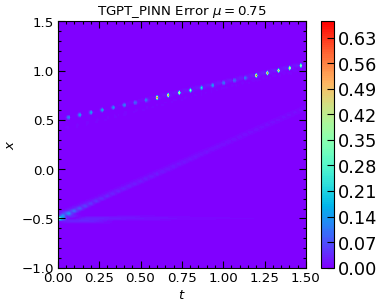

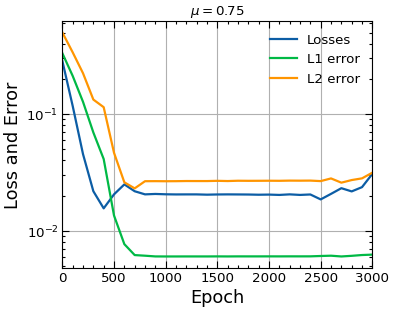

GPT-PINN at [0.   0.75] with the Loss=0.03073616698384285, rMAE = 0.006232904270291328, rRMSE = 0.0314483642578125


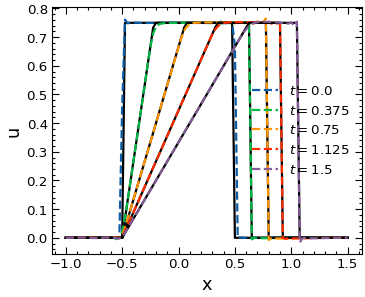

[0.  0.8] stopped at epoch: 0 | gpt_loss: 0.19321461021900177,rMAE: [0.2501113712787628], rRMSE:[0.4101696312427521], 0.03202902898192406, 0.015977101400494576, 2.8900728921144037e-08, 0.00014142683357931674
[0.  0.8] stopped at epoch: 500 | gpt_loss: 0.02491813711822033,rMAE: 0.006540957372635603, rRMSE:0.02802273817360401, 0.0249057337641716, 1.2261698429938406e-06, 1.412450068016824e-08, 4.903342488982165e-12
[0.  0.8] stopped at epoch: 1000 | gpt_loss: 0.025211505591869354,rMAE: 0.006352563854306936, rRMSE:0.02840232290327549, 0.025049960240721703, 7.797594321345969e-07, 1.4285212124320879e-08, 1.5360441466327757e-05
[0.  0.8] stopped at epoch: 1500 | gpt_loss: 0.024648940190672874,rMAE: 0.006094218697398901, rRMSE:0.026693124324083328, 0.024645399302244186, 3.3993507031482295e-07, 1.4138605841651497e-08, 5.190798745696723e-12
[0.  0.8] stopped at epoch: 2000 | gpt_loss: 0.02766314521431923,rMAE: 0.006126837804913521, rRMSE:0.027825916185975075, 0.02627132646739483, 3.7501430938391

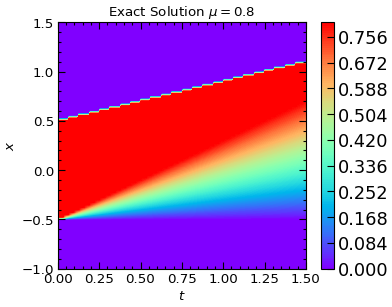

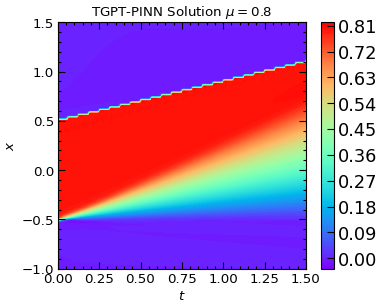

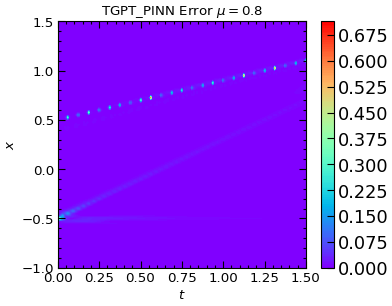

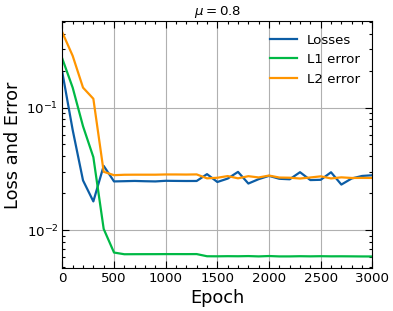

GPT-PINN at [0.  0.8] with the Loss=0.02798176184296608, rMAE = 0.006076503079384565, rRMSE = 0.026588762179017067


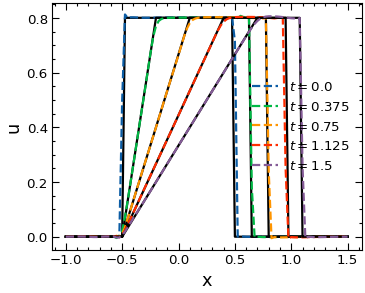

[0.   0.85] stopped at epoch: 0 | gpt_loss: 0.12299291789531708,rMAE: [0.17650346457958221], rRMSE:[0.3238341808319092], 0.03174959868192673, 0.008982876315712929, 2.8900728921144037e-08, 0.00014142683357931674
[0.   0.85] stopped at epoch: 500 | gpt_loss: 0.03040372207760811,rMAE: 0.008451669476926327, rRMSE:0.05913757532835007, 0.03039908967912197, 4.4652850306192704e-07, 1.6650963274855712e-08, 4.536644931246725e-12
[0.   0.85] stopped at epoch: 1000 | gpt_loss: 0.03153920918703079,rMAE: 0.00817029643803835, rRMSE:0.05687897652387619, 0.03127013519406319, 2.0178769943868247e-07, 1.716466613288503e-08, 2.6688458092394285e-05
[0.   0.85] stopped at epoch: 1500 | gpt_loss: 0.028381938114762306,rMAE: 0.007958849892020226, rRMSE:0.05217848718166351, 0.027845842763781548, 2.522417901218432e-07, 1.71369780588293e-08, 5.334028537617996e-05
[0.   0.85] stopped at epoch: 2000 | gpt_loss: 0.031385909765958786,rMAE: 0.008170687593519688, rRMSE:0.05688943713903427, 0.03138371556997299, 2.0229289

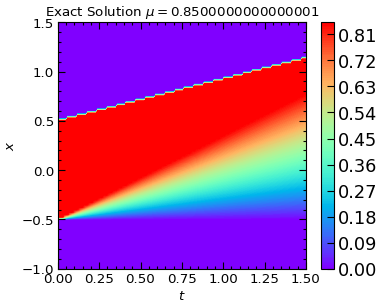

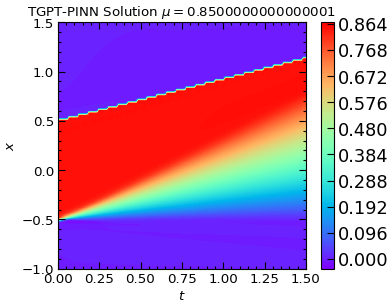

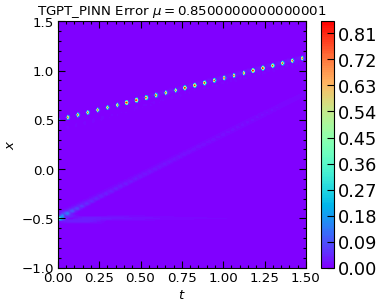

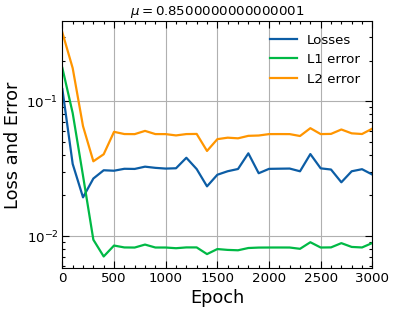

GPT-PINN at [0.   0.85] with the Loss=0.028462307527661324, rMAE = 0.008830702863633633, rRMSE = 0.06249041482806206


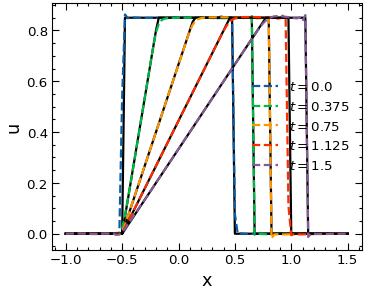

[0.  0.9] stopped at epoch: 0 | gpt_loss: 0.0750902071595192,rMAE: [0.1114070862531662], rRMSE:[0.24069209396839142], 0.03378908336162567, 0.003988656681030989, 2.8900728921144037e-08, 0.00014142683357931674
[0.  0.9] stopped at epoch: 500 | gpt_loss: 0.036183055490255356,rMAE: 0.006707256194204092, rRMSE:0.03996461629867554, 0.03567179664969444, 3.358005926656915e-07, 1.8688689706891637e-08, 5.0771308451658115e-05
[0.  0.9] stopped at epoch: 1000 | gpt_loss: 0.03409556671977043,rMAE: 0.007066750433295965, rRMSE:0.044878680258989334, 0.03409276902675629, 2.6078888026859204e-07, 1.895868528833944e-08, 5.9845002217673304e-12
[0.  0.9] stopped at epoch: 1500 | gpt_loss: 0.03691133111715317,rMAE: 0.007423222530633211, rRMSE:0.04896562919020653, 0.03690873086452484, 2.41051623106614e-07, 1.9077916135756823e-08, 6.103245079464026e-12
[0.  0.9] stopped at epoch: 2000 | gpt_loss: 0.03923139348626137,rMAE: 0.006414021831005812, rRMSE:0.034873876720666885, 0.03858359530568123, 5.058425927018106e

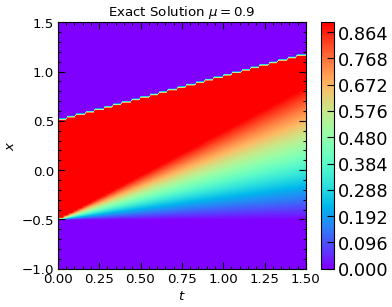

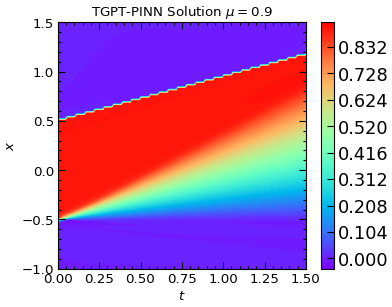

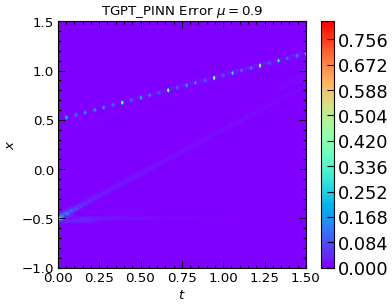

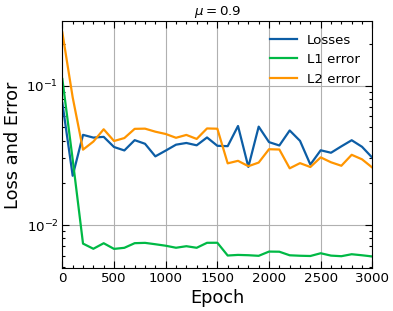

GPT-PINN at [0.  0.9] with the Loss=0.030291689559817314, rMAE = 0.005916415248066187, rRMSE = 0.02573917992413044


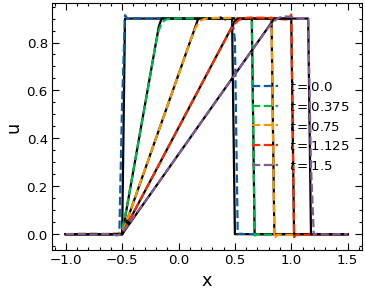

[0.   0.95] stopped at epoch: 0 | gpt_loss: 0.049506355077028275,rMAE: [0.053974635899066925], rRMSE:[0.1551651507616043], 0.038147490471601486, 0.0009944307385012507, 2.8900728921144037e-08, 0.00014142683357931674
[0.   0.95] stopped at epoch: 500 | gpt_loss: 0.042701609432697296,rMAE: 0.005696325562894344, rRMSE:0.018387330695986748, 0.04202147573232651, 9.579944162396714e-07, 2.2295200352573374e-08, 6.703340477542952e-05
[0.   0.95] stopped at epoch: 1000 | gpt_loss: 0.04983315244317055,rMAE: 0.005587917286902666, rRMSE:0.02051045000553131, 0.046693384647369385, 4.869934286944044e-07, 2.1801096039553158e-08, 0.00031346804462373257
[0.   0.95] stopped at epoch: 1500 | gpt_loss: 0.04407801479101181,rMAE: 0.005563738290220499, rRMSE:0.020575372502207756, 0.04363944008946419, 4.051412361150142e-07, 2.1630270907735394e-08, 4.343053660704754e-05
[0.   0.95] stopped at epoch: 2000 | gpt_loss: 0.04358167573809624,rMAE: 0.005562737118452787, rRMSE:0.02055278606712818, 0.043143127113580704, 4

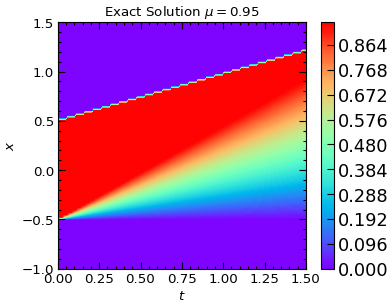

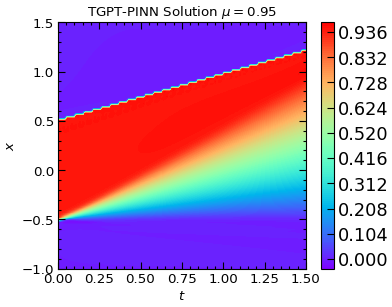

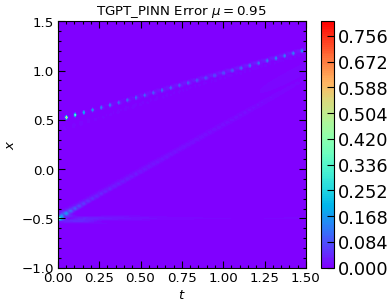

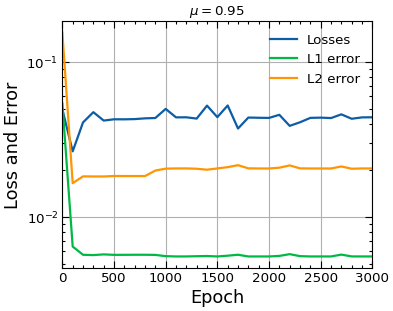

GPT-PINN at [0.   0.95] with the Loss=0.04399959743022919, rMAE = 0.0055633834563195705, rRMSE = 0.02057076431810856


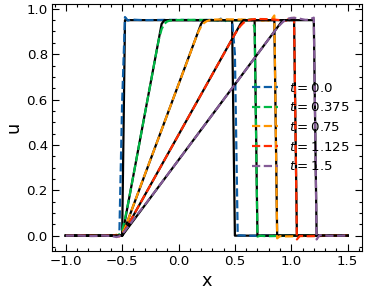

[0. 1.] stopped at epoch: 0 | gpt_loss: 0.04624142870306969,rMAE: [0.006505290977656841], rRMSE:[0.03564750775694847], 0.044824812561273575, 2.0571329173435515e-07, 2.8900728921144037e-08, 0.00014142683357931674
[0. 1.] stopped at epoch: 500 | gpt_loss: 0.0523059107363224,rMAE: 0.006353340577334166, rRMSE:0.03572775796055794, 0.05088900029659271, 2.344370670925855e-07, 2.9525331513013953e-08, 0.00014142683357931674
[0. 1.] stopped at epoch: 1000 | gpt_loss: 0.03056909702718258,rMAE: 0.008155515417456627, rRMSE:0.052661024034023285, 0.029142925515770912, 1.5033126601338154e-06, 2.6184951096297482e-08, 0.00014108778850641102
[0. 1.] stopped at epoch: 1500 | gpt_loss: 0.05418926104903221,rMAE: 0.007464919704943895, rRMSE:0.050324831157922745, 0.05418567359447479, 3.345768391227466e-07, 2.42698980912337e-08, 1.0838895753151334e-11
[0. 1.] stopped at epoch: 2000 | gpt_loss: 0.0520043708384037,rMAE: 0.0063582356087863445, rRMSE:0.035844169557094574, 0.05037302523851395, 2.3248519198659778e-0

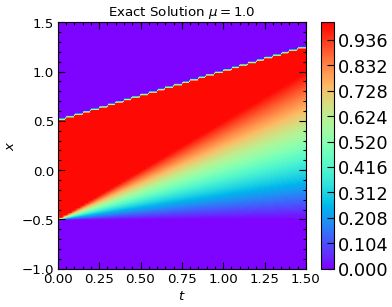

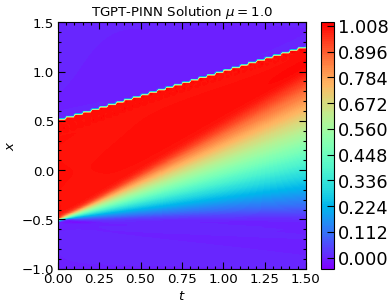

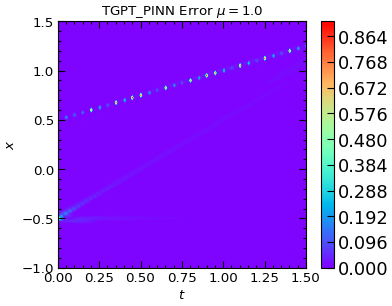

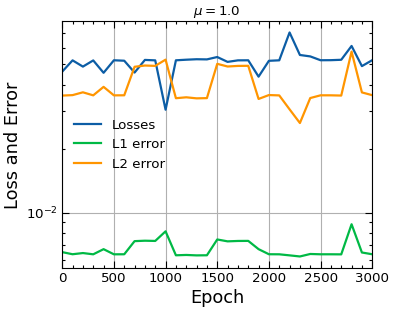

GPT-PINN at [0. 1.] with the Loss=0.0523655042052269, rMAE = 0.006356761325150728, rRMSE = 0.035792276263237


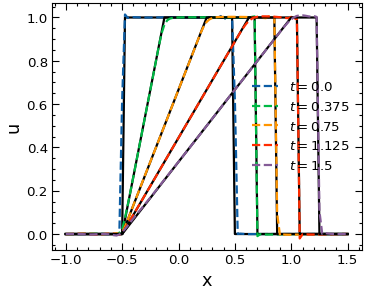

Largest Loss: 0.0523655042052269 at [0. 1.]
Largest L1: 0.0194994006305933 at [0.  0.5]
Largest L2: 0.07411359250545502 at [0.  0.5]
Loss:[0.013720854185521603, 0.008840837515890598, 0.010990702547132969, 0.014487936161458492, 0.02040102891623974, 0.03073616698384285, 0.02798176184296608, 0.028462307527661324, 0.030291689559817314, 0.04399959743022919, 0.0523655042052269]
L1:[0.0194994006305933, 0.0063441041857004166, 0.006370834074914455, 0.0067191277630627155, 0.007192057091742754, 0.006232904270291328, 0.006076503079384565, 0.008830702863633633, 0.005916415248066187, 0.0055633834563195705, 0.006356761325150728]
L2:[0.07411359250545502, 0.027226563543081284, 0.028816616162657738, 0.03626095503568649, 0.042373958975076675, 0.0314483642578125, 0.026588762179017067, 0.06249041482806206, 0.02573917992413044, 0.02057076431810856, 0.035792276263237]


In [6]:
i=0   
lr_gpt          = 0.001
epochs_gpt      = 3000
tol_gpt         = 1e-4
############################ GPT-PINN Training ############################
layers_gpt = np.array([2, i+1, 1])
c_initial  = torch.full((1,i+1), 1/(i+1))
nu_loss = []
L1_err  = []
L2_err  = []
Cor_err =  []

gpt_train_time_1 = time.perf_counter()
for nu in nu_training:
    Exact_y0 = exact_u(nu,xt_test)[:,None].to(device)

    IC_data = create_IC_data(nu, Xi, Xf, Ti, Tf, IC_pts, IC_simple)
    IC_xt     = IC_data[0].to(device)
    IC_u      = IC_data[1].to(device)

    #print((P_list[0]).linears[0].bias)
    GPT_PINN = GPT(nu, layers_gpt, P_list[0:i+1], c_initial,xt_resid, f_hat, Exact_y0, xt_test, IC_xt, IC_u,  BC1, BC2,xt_RHL, xt_RHR,xt_RHt,xt_RHtL,Nx_train,Nt_train,dt).to(device)

    gpt_losses = gpt_train(GPT_PINN, nu, xt_resid, f_hat, Exact_y0, xt_test, IC_xt, IC_u, BC1, BC2, epochs_gpt, lr_gpt, tol_gpt)

    nu_loss.append(gpt_losses[0].item())
    L1_err.append(gpt_losses[3][-1])
    L2_err.append(gpt_losses[4][-1])


    Burgers_plot(xt_test, Exact_y0, Nx_test,Nt_test,title=fr"Exact Solution $\mu={nu[1]}$")
    Burgers_plot(xt_test, GPT_PINN.forward(xt_test), Nx_test,Nt_test,title=fr"TGPT-PINN Solution $\mu={nu[1]}$")
    Burgers_plot(xt_test, abs(GPT_PINN.forward(xt_test)-Exact_y0), Nx_test,Nt_test,title=fr"TGPT_PINN Error $\mu={nu[1]}$")

    plt.figure(dpi=80, figsize=(5,4))    
    plt.plot(gpt_losses[1], gpt_losses[2], label="Losses")
    plt.plot(gpt_losses[1], gpt_losses[3], label="L1 error")
    plt.plot(gpt_losses[1], gpt_losses[4], label="L2 error")
    #plt.plot(gpt_losses[1], gpt_losses[5], label="Loss_implict")
    #plt.plot(gpt_losses[1], gpt_losses[8], label="Loss_Res")
    #plt.plot(gpt_losses[1], gpt_losses[6], label="Loss_IC")
    #plt.plot(gpt_losses[1], gpt_losses[7], label="Loss_BC")

    plt.xlabel("Epoch",     fontsize=16)
    plt.ylabel("Loss and Error", fontsize=16)

    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=12)
    
    plt.grid(True)
    plt.xlim(0,max(gpt_losses[1]))
    plt.yscale('log')
    plt.title(fr"$\mu={nu[1]}$", fontsize=12)
    plt.legend(fontsize = 12)#
    plt.show()

    #err =exact_u_err(Exact_y0,GPT_PINN(xt_test),xt_test,nu)[1]
    #Cor_err.append(err.item())
    #print(f"GPT-PINN at {nu} with the Loss={gpt_losses[0].item()}, rMAE = {gpt_losses[3][-1]}, rRMSE = {gpt_losses[4][-1]} and Cor error = {err.item()}")
    print(f"GPT-PINN at {nu} with the Loss={gpt_losses[0].item()}, rMAE = {gpt_losses[3][-1]}, rRMSE = {gpt_losses[4][-1]}")

    plt.figure(dpi=80, figsize=(5,4))#dpi=150, figsize=(10,8)
    for ind in range(1, Nt_test+1,50):
        plt.plot(xt_test[0:Nx_test,0].detach().cpu(),Exact_y0[(ind-1)*Nx_test:ind*Nx_test,0].detach().cpu(),'k')
        #plt.scatter(xt_test[0:Nx_test,0].detach().cpu(),PINN(xt_test)[(ind-1)*Nx_test:ind*Nx_test,0].detach().cpu(),s=20,label=fr"$t={round((ind-1)*(Tf-Ti)/(Nt_test-1),3)}$")
        plt.plot(xt_test[0:Nx_test,0].detach().cpu(),GPT_PINN.forward(xt_test)[(ind-1)*Nx_test:ind*Nx_test,0].detach().cpu(),'--',label=fr"$t={round((ind-1)*(Tf-Ti)/(Nt_test-1),3)}$")
    plt.xlabel("x",     fontsize=16)
    plt.ylabel("u", fontsize=16)

    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=12)

    plt.legend(fontsize = 12)#
    plt.show()

        
print(f"Largest Loss: {max(nu_loss)} at {nu_training[nu_loss.index(max(nu_loss))]}")
print(f"Largest L1: {max(L1_err)} at {nu_training[L1_err.index(max(L1_err))]}")
print(f"Largest L2: {max(L2_err)} at {nu_training[L2_err.index(max(L2_err))]}") 

print(f"Loss:{nu_loss}")
print(f"L1:{L1_err}")
print(f"L2:{L2_err}")

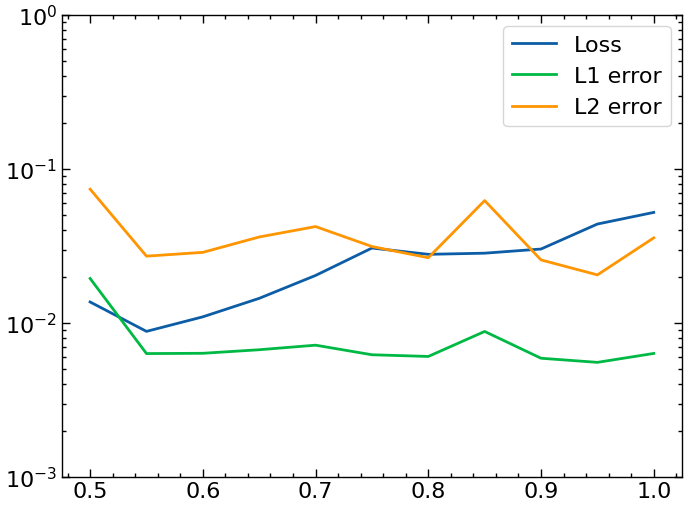

In [7]:
plt.errorbar(nu2_training,nu_loss,label='Loss')
plt.errorbar(nu2_training,L1_err,label='L1 error')
plt.errorbar(nu2_training,L2_err,label='L2 error')
plt.legend(frameon=True)
plt.ylim(1e-3,1)
plt.yscale('log')

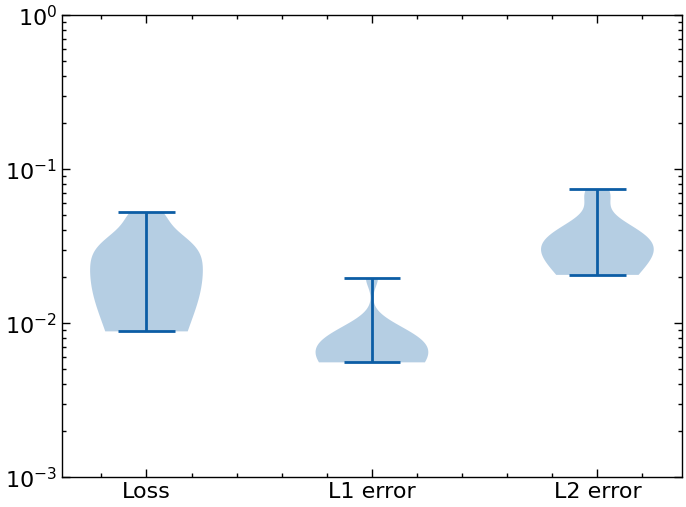

In [8]:
plt.violinplot([nu_loss, L1_err, L2_err ])
plt.xticks([1, 2, 3], ['Loss', 'L1 error', 'L2 error'])
plt.ylim(1e-3,1)
plt.yscale('log')

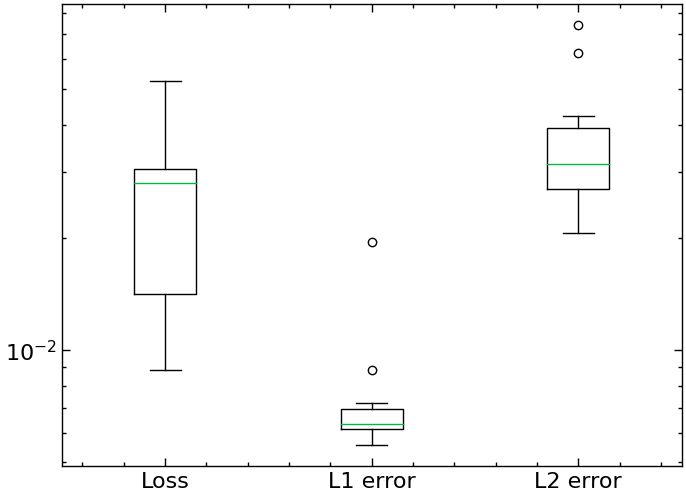

In [9]:
plt.boxplot([nu_loss, L1_err, L2_err], labels=['Loss', 'L1 error', 'L2 error'])
plt.yscale('log')